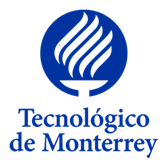

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 3

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Cargando Conjunto de Datos**

In [1]:
!pip install langchain

In [2]:
!pip install langchain-community

In [3]:
!pip install langchain-text-splitters

In [4]:
!pip install langchain-aws

In [5]:
# Importando librerias requeridas
import re
import json
import uuid
import io
import logging
import multiprocessing
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import s3fs
import boto3
from langchain.text_splitter import CharacterTextSplitter

In [6]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
logging.basicConfig(
    filename='../logs/Avance3_Equipo37_S3_Upload_Job.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [7]:
CHUNK_SIZE = 1500
CHUNK_OVERLAP = 100
SOURCE_AWS_BUCKET = 'volindo-hotel-data'
OUTPUT_AWS_BUCKET = 'chunked-hotel-data'
OUTPUT_DATA_SET = f''
SOURCE_DATA_SET = f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/parquet4p/'
SOURCE_FILE_DATA_SET = [
    f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/parquet4p/hotel-data-set-part0.snappy.parquet',
    f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/parquet4p/hotel-data-set-part1.snappy.parquet',
    f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/parquet4p/hotel-data-set-part2.snappy.parquet',
    f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/parquet4p/hotel-data-set-part3.snappy.parquet'
]
#LOCAL_SET = '../local-data/hotel-data-set.snappy.parquet'


## **Generación de Archivos de Datos para AWS Bedrock**



Para crear la base de conocimiento, o knowledge base, usando un tamaño de pedazo a la medida, o custom chunk size, es necesario generar dos archivos por cada hotel en conjunto de datos. Un archivo tipo texto contiene la descripción del hotel y el otro archivo contiene los metadatos para el hotel (AWS, s.f., Monigatti, 2023).

In [8]:
def generate_data_chunks(source_file_name, idx):
    logger.info(f'Hilo {idx} - Empezando procesamiento de registros.')
    # Creando sistemas de archivos para bucket de S3
    awsfs = s3fs.S3FileSystem()

    # Creando cliente para AWS S3
    s3_client = boto3.client('s3')

    # Cargando archivo con los códigos de país y sus nombres. Se van a remover las columnas de códigos alfabético
    # de 3 caracteres y numérico por que no se necesitan para preparar el texto extendido de la descripción 
    ccdf_full = pd.read_csv('../country-code.csv')
    ccdf_full.loc[ccdf_full.isna().any(axis=1),'Alpha2'] = 'NA'
    ccdf = ccdf_full.drop(['Alpha3','UNCode'],axis=1)
    # Usando el código alfabético del país como índice y creando un diccionario con el conjunto de datos
    ccdf = ccdf.set_index('Alpha2')
    ccdict = ccdf.to_dict('index')

    # Cargando conjunto de datos de hoteles como un Dataset multi-parte de Apache Parquet
    dataset = pq.ParquetDataset(source_file_name, filesystem=awsfs)
    #dataset = pq.ParquetDataset(LOCAL_SET)
    table = dataset.read()
    # Creando un Dataframe de Pandas para el analisis
    dataframe = table.to_pandas()
    logger.info(f'Hilo {idx} - Conjunto de datos leido de {source_file_name} con dimensiones {dataframe.shape}.')

    # Inicializando contador de registros
    subi = 0

    # Creando text splitter
    text_splitter = CharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

    # Generando dos archivos por cada registro en el conjunto de datos
    for row in dataframe.itertuples():
        # Almancenando valores a usarse en nombres de archivo o en otras variables
        hotel_desc_chunks = text_splitter.split_text(row.Description)

        # Usando el nombre completo del país y el continente si código del país del registro existe en el
        # diccionario de códigos y nombres 
        long_country_name = ''
        long_continent_name = ''
        if row.CountryCode in ccdict and ccdict[row.CountryCode]['Country'] is not None:
            long_country_name = ccdict[row.CountryCode]['Country']
            long_continent_name = ccdict[row.CountryCode]['Continent']

        # Creando creando objeto JSON con los metadatos seleccionados
        metadata = {
            'metadataAttributes' : {
                'Code' : row.HotelCode,
                'Name' : row.HotelName,
                'Address' : row.Address,
                'City' : row.CityName,
                'CountryCode' : row.CountryCode,
                'Country' : long_country_name,
                'Continent' : long_continent_name,
                'Rating' : row.HotelRating,
                'Longitude' : row.Longitude,
                'Latitude' : row.Latitude
            }
        }
        json_object = json.dumps(metadata, indent=2)

        for cidx, hotel_desc_chunk in enumerate(hotel_desc_chunks):
            # Generando nombres únicos de archivo para el archivo con la descripción y el archivo con los metadatos
            file_name_base = f'{row.HotelCode}-{uuid.uuid1().hex}.txt'
            file_name_desc = f'{OUTPUT_DATA_SET}{file_name_base}'
            file_name_meta = f'{file_name_desc}.metadata.json'
        
            # Escribiendo archivos, un pedazo de descripción a la vez
            with io.StringIO(hotel_desc_chunk) as textfile:
                response = s3_client.put_object(
                    Bucket=OUTPUT_AWS_BUCKET, Key=file_name_desc, Body=textfile.getvalue()
                )
                status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
                if status != 200:
                    logger.info(f'Hilo {idx} - Texto para hotel {row.HotelCode}-{cidx} - {status}')
            
            with io.StringIO(json_object) as jsonfile:
                response = s3_client.put_object(
                    Bucket=OUTPUT_AWS_BUCKET, Key=file_name_meta, Body=jsonfile.getvalue()
                )
                status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
                if status != 200:
                    logger.info(f'Hilo {idx} - Metadatos para hotel {row.HotelCode}-{cidx} - {status}')
    
        # Imprimiendo cuenta de registros procesados
        # El ciclo termina una vez procesados 1000 registros
        subi += 1
        #if subi > 4:
        #    break
    logger.info(f'Hilo {idx} - {subi} registros procesados.')

In [9]:
for idx, source_file in enumerate(SOURCE_FILE_DATA_SET):
    generate_data_chunks(source_file, idx)

## **Actividades para la Siguiente Etapa**



## **Conclusiones**



‌

## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* AWS. (s.f.). Set up a data source for your knowledge base - Amazon Bedrock. docs.aws.amazon.com. Recuperado 7 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base-ds.html

* ISO. (s.f.) ISO 3166 — Country Codes. Internation Standards Organization. Recuperado 3 de mayo, 2024 de https://www.iso.org/iso-3166-country-codes.html

